# 0. Dataset & model import

In [1]:
# Connect to database
from LoadProstateX import ProstateXImageStorage
dataset = ProstateXImageStorage(r'C:\Users\mayso\Desktop\manifest-1605042674814\PROSTATEx')
dataset.loadImages()

Found 98 subjects and 98 segmentations


In [2]:
EPOCHS = 20
N_AUGMENT = 4
BATCH_SIZE = 10
INPUT_SHAPE = (400, 400, 3)
VALIDATION_SPLIT = 0.8
N_BATCHS = 90//BATCH_SIZE

In [3]:
# Creating pipeline to normalize & augment data
import tensorflow as tf
import numpy as np

# Resizing and rescaling pipeline
resize = tf.keras.layers.Resizing(INPUT_SHAPE[0], INPUT_SHAPE[1])

def rescale_img(input_img): #va être inclut dans le modèle direct
    rescale = tf.keras.layers.Rescaling(2./input_img.max(), offset=-1)
    return rescale(input_img)

In [4]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import backend as K

# Define loss and optimizer
@keras.saving.register_keras_serializable('Custom')
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def dice_coef(y_true, y_pred, smooth=0):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

In [5]:
unet_model = tf.keras.models.load_model(r'C:\Users\mayso\Desktop\Prostate segmentation\UNETV3_model_chkpt18.h5')

# 1.Process DICE for test data

[Median] ~[var] of DICE over selected subjects : 0.91 ~0.0813


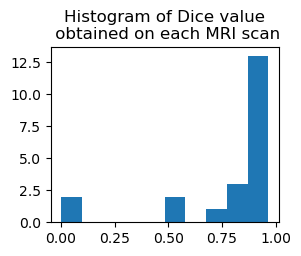

In [7]:
import matplotlib.pyplot as plt
# process DICE for each scan
global_DICE_list = []

tests_subj = [8,9,18,19,28,29,38,39,48,49,58,59,68,69,78,79,88,89,90,91,92,93,94,95,96,97]

train_subj = []
for i in range(98):
    if i not in tests_subj:
        train_subj.append(i)

for subj in tests_subj:
    first = True
    dataset.getData(subj)
    
    segmentations=[]
    all_inputs = []
    volume = dataset.outputImg
    segmentation = dataset.outputSeg
    
    # Making it 3 dimensional
    volume_output = np.expand_dims(volume, axis=3)
    segmentation_output = np.expand_dims(segmentation, axis=3)
    # resize and rescale volume
    volume_reshape = [resize(rescale_img(volume_output[i,:,:])) for i in range(len(volume_output))]
    segmentation_reshape = [resize(segmentation_output[i,:,:]) for i in range(len(segmentation_output))]
    volumes, segmentations_or = np.array([volume_reshape]),segmentation_reshape
            
    inputs = np.zeros((len(segmentation_reshape),INPUT_SHAPE[0],INPUT_SHAPE[1],3))
  
    for v in range(len(volumes)):
        for j in range(len(volumes[v])):
            inputs[j+len(volumes[0])*v,:,:,1] =  np.squeeze(volumes[v][j])
            if j!=0:
                inputs[j+len(volumes[0])*v,:,:,0] =  np.squeeze(volumes[v][j-1])
            if j!=(len(volumes[0])-1):
                inputs[j+len(volumes[0])*v,:,:,2] =  np.squeeze(volumes[v][j+1])

            segmentations.append(segmentations_or[j+len(volumes[0])*v])
    if not first:
        all_inputs = np.concatenate((all_inputs, inputs))
    else:
        all_inputs = inputs.copy()
        first = False

        vol_dice = []
        
for img in range(len(all_inputs)):
    pred = unet_model(np.array([all_inputs[img]]))
    dice = dice_coef(pred, segmentations[img])
    global_DICE_list.append(dice)

# plot histogram for dice values and mean dice
fig = plt.figure(figsize=(10,5))

figure = fig.add_subplot(2, 3, 1)
plt.hist(global_DICE_list)

plt.title("Histogram of Dice value\n obtained on each MRI scan")
print(f"[Median] ~[var] of DICE over selected subjects : {np.median(global_DICE_list):.2f} ~{np.var(global_DICE_list):.4f}")

# 2. Plot results for a subject

In [18]:
import matplotlib.pyplot as plt
#subj = np.random.randint(70, dataset.nbSubjects) # 8 last subject kept for validation
subj = 96
dataset.getData(subj)
volume, segmentation = dataset.outputImg, dataset.outputSeg
img = np.random.randint(0, len(dataset.outputSeg))

# Making it 3 dimensional
volume_output = np.expand_dims(volume, axis=3)
segmentation_output = np.expand_dims(segmentation, axis=3)
# resize and rescale volume
volume_reshape = [resize(rescale_img(volume_output[i,:,:])) for i in range(len(volume_output))]
segmentation_reshape = [resize(segmentation_output[i,:,:]) for i in range(len(segmentation_output))]
volumes, segmentations_or = np.array([volume_reshape]),segmentation_reshape
            
inputs = np.zeros((len(segmentation_reshape),INPUT_SHAPE[0],INPUT_SHAPE[1],3))
   
for v in range(len(volumes)):
    for j in range(len(volumes[v])):
        inputs[j+len(volumes[0])*v,:,:,1] =  np.squeeze(volumes[v][j])
        if j!=0:
            inputs[j+len(volumes[0])*v,:,:,0] =  np.squeeze(volumes[v][j-1])
        if j!=(len(volumes[0])-1):
            inputs[j+len(volumes[0])*v,:,:,2] =  np.squeeze(volumes[v][j+1])

        segmentations.append(segmentations_or[j+len(volumes[0])*v])
all_inputs = inputs.copy()

# Shows every predictions from subject
figure = plt.figure(figsize = (150,250))
for img in range(len(all_inputs)):
    pred = unet_model(np.array([all_inputs[img]]))
    fig = figure.add_subplot(10, 6, 2*img+1)
    plt.imshow(255*np.concatenate((pred[0],segmentations_or[img],np.zeros((400,400,1))), axis = 2))
    plt.title(f"DICE = {dice_coef(pred, segmentations_or[img]):.2f}", fontsize = 110)
    fig = figure.add_subplot(10, 6, 2*(img+1))
    plt.imshow(volume_reshape[img], cmap='gray')
#plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
print(f"Subject N° {subj}\n Green = ground truth segmentation, Red = predicted segmentation")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Subject N° 96
 Green = ground truth segmentation, Red = predicted segmentation
